In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve

In [2]:
# ----------------------------------------------------------------------
# 0. LOAD CLEANED DATA
# ----------------------------------------------------------------------

DATA_PATH = "data/default_cc_clean_stage1.csv"

df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
print(df.head())

#(space vs dot)
possible_targets = ["default.payment.next.month", "default payment next month"]
TARGET_COL = None
for col in possible_targets:
    if col in df.columns:
        TARGET_COL = col
        break

if TARGET_COL is None:
    raise ValueError("Target column not found. Check the column name in your CSV.")

print("\nUsing target column:", TARGET_COL)

Shape: (30000, 24)
   LIMIT_BAL  SEX  EDUCATION  MARRIAGE   AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0    20000.0    2          2         1  24.0      2      2     -1     -1   
1   120000.0    2          2         2  26.0     -1      2      0      0   
2    90000.0    2          2         2  34.0      0      0      0      0   
3    50000.0    2          2         1  37.0      0      0      0      0   
4    50000.0    1          2         1  57.0     -1      0     -1      0   

   PAY_5  ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
0     -2  ...        0.0        0.0        0.0       0.0     689.0       0.0   
1      0  ...     3272.0     3455.0     3261.0       0.0    1000.0    1000.0   
2      0  ...    14331.0    14948.0    15549.0    1518.0    1500.0    1000.0   
3      0  ...    28314.0    28959.0    29547.0    2000.0    2019.0    1200.0   
4      0  ...    20940.0    19146.0    19131.0    2000.0   36681.0   10000.0   

   PAY_AMT4  PAY_AMT5  PAY_AMT6  default pa

In [3]:
cat_cols = [
    "SEX",
    "EDUCATION",
    "MARRIAGE",
    "PAY_0",
    "PAY_2",
    "PAY_3",
    "PAY_4",
    "PAY_5",
    "PAY_6",
]

num_cols = [c for c in df.columns if c not in cat_cols + [TARGET_COL]]

X = df[cat_cols + num_cols]
y = df[TARGET_COL]

print("\nCategorical columns:", cat_cols)
print("Numeric columns:", num_cols)

print("\nTarget distribution:")
print(y.value_counts(normalize=True))



Categorical columns: ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
Numeric columns: ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

Target distribution:
default payment next month
0    0.7788
1    0.2212
Name: proportion, dtype: float64


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y,
)

print("\nTrain shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (21000, 23)
Test shape: (9000, 23)



Fitting Random Forest PD model...

[Random Forest] Test ROC AUC: 0.7743
[Random Forest] Test KS statistic: 0.4233


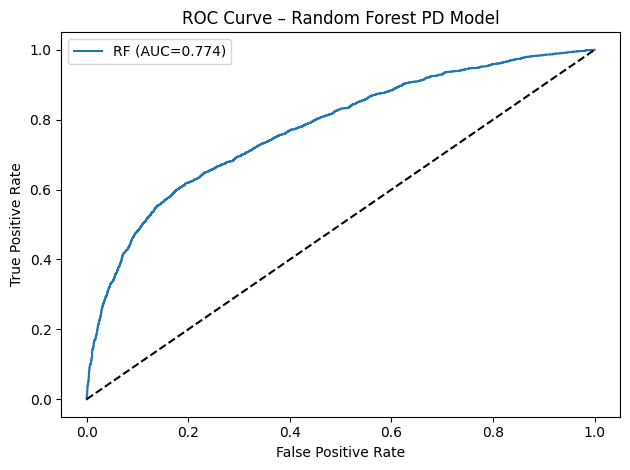

In [5]:
# ----------------------------------------------------------------------
# 3. PREPROCESSING + PD MODEL (Random Forest)
# ----------------------------------------------------------------------

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ]
)

rf_clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight="balanced",
    n_jobs=-1,
    random_state=42,
)

rf_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", rf_clf),
    ]
)

print("\nFitting Random Forest PD model...")
rf_pipeline.fit(X_train, y_train)

# Predicted PDs 
y_proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]


auc_rf = roc_auc_score(y_test, y_proba_rf)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
ks_rf = np.max(tpr_rf - fpr_rf)

print(f"\n[Random Forest] Test ROC AUC: {auc_rf:.4f}")
print(f"[Random Forest] Test KS statistic: {ks_rf:.4f}")

plt.figure()
plt.plot(fpr_rf, tpr_rf, label=f"RF (AUC={auc_rf:.3f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Random Forest PD Model")
plt.legend()
plt.tight_layout()
plt.show()

In [6]:
# ----------------------------------------------------------------------
# 4. BUILD TEST-SET DATAFRAME WITH PD, EAD, LGD, EL
# ----------------------------------------------------------------------

# Start from test features
df_test = X_test.copy()
df_test[TARGET_COL] = y_test.values

# 4.1 PD from the model
df_test["PD_model"] = y_proba_rf

# 4.2 EAD, real bank data you could use current exposure, EAD models, etc.
df_test["EAD"] = df_test["LIMIT_BAL"]

# 4.3 LGD
LGD_ASSUMPTION = 0.5  # 50% loss given default
df_test["LGD"] = LGD_ASSUMPTION

# 4.4 EL
df_test["EL"] = df_test["PD_model"] * df_test["LGD"] * df_test["EAD"]

print("\nTest-set sample with PD, EAD, LGD, EL:")
print(df_test[[TARGET_COL, "PD_model", "EAD", "LGD", "EL"]].head())

print("\nTotal EAD (test set):", df_test["EAD"].sum())
print("Total EL  (test set):", df_test["EL"].sum())


Test-set sample with PD, EAD, LGD, EL:
       default payment next month  PD_model       EAD  LGD            EL
8941                            0  0.111939  230000.0  0.5  12872.956630
17618                           1  0.578677   80000.0  0.5  23147.087754
27895                           0  0.133720  100000.0  0.5   6686.006205
16103                           0  0.643383   10000.0  0.5   3216.913971
4422                            0  0.095128  110000.0  0.5   5232.058704

Total EAD (test set): 1507047680.0
Total EL  (test set): 178782130.0339595



Risk by PD decile (1 = safest, 10 = riskiest):
           n_obs    avg_PD    total_EAD      total_EL  EL_share
PD_DECILE                                                      
1            900  0.059278  240690000.0  6.912698e+06  0.038665
2            900  0.103647  201520000.0  1.037012e+07  0.058004
3            900  0.137266  176580000.0  1.206008e+07  0.067457
4            900  0.168693  159540000.0  1.341980e+07  0.075062
5            900  0.201722  148400000.0  1.494641e+07  0.083601
6            900  0.237185  140280000.0  1.664328e+07  0.093093
7            900  0.285445  130120000.0  1.852118e+07  0.103596
8            900  0.377603  112377680.0  2.115253e+07  0.118315
9            900  0.547289  102150000.0  2.814063e+07  0.157402
10           900  0.774827   95390000.0  3.661541e+07  0.204805


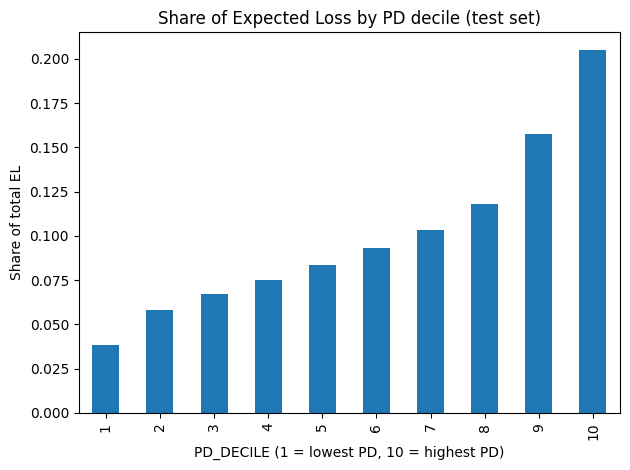

In [7]:
# ----------------------------------------------------------------------
# 5. RISK BUCKETS BY PD (DECILES)
# ----------------------------------------------------------------------

# (10 buckets, 1=lowest PD, 10=highest PD)
df_test["PD_DECILE"] = pd.qcut(
    df_test["PD_model"],
    q=10,
    labels=False,
    duplicates="drop"
) + 1  # labels 1..10

# risk measures by decile
risk_by_decile = (
    df_test
    .groupby("PD_DECILE")
    .agg(
        n_obs=("PD_model", "size"),
        avg_PD=("PD_model", "mean"),
        total_EAD=("EAD", "sum"),
        total_EL=("EL", "sum"),
    )
)

risk_by_decile["EL_share"] = risk_by_decile["total_EL"] / risk_by_decile["total_EL"].sum()

print("\nRisk by PD decile (1 = safest, 10 = riskiest):")
print(risk_by_decile)

# Expected Loss
plt.figure()
risk_by_decile["EL_share"].plot(kind="bar")
plt.title("Share of Expected Loss by PD decile (test set)")
plt.xlabel("PD_DECILE (1 = lowest PD, 10 = highest PD)")
plt.ylabel("Share of total EL")
plt.tight_layout()
plt.show()

In [8]:

import os
os.makedirs("data", exist_ok=True)

OUTPUT_TEST_PATH = "data/default_cc_pd_el_test.csv"
df_test.to_csv(OUTPUT_TEST_PATH, index=False)
print(f"\nSaved test-set PD/EL results to: {OUTPUT_TEST_PATH}")


Saved test-set PD/EL results to: data/default_cc_pd_el_test.csv
